In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Load dataxq
pd_data = pd.read_csv('../../datasets/boston.csv')

In [3]:

X = pd_data.drop(columns=['CRIM','NOX','B','MEDV','TAX',"INDUS","CHAS","RAD","ZN"])
y = pd_data['MEDV'] 

print(X.columns)



X.columns = [
    # 'Crime Rate',
    # '% Residential in Area', 
    # '% Business in Area', 
    # 'River', 
    # 'Air Pollution',
    '#Rooms',
    '% Pre-1940 Units',
    'Dist to Biz', 
    # 'Highway Accessibility',
    # 'Property Tax Rate',
    'Stu-Tea Ratio',
    '% Lower Income',
]

Index(['RM', 'AGE', 'DIS', 'PTRATIO', 'LSTAT'], dtype='object')


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# 训练测试集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练 RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
preds = rf.predict(X_test) 
r2_socre_ = r2_score(y_test, preds)
print(r2_socre_)
rmse_score = np.sqrt(np.mean((y_test - preds) ** 2))
print(rmse_score)

0.8511090923081788
3.3043506985814455


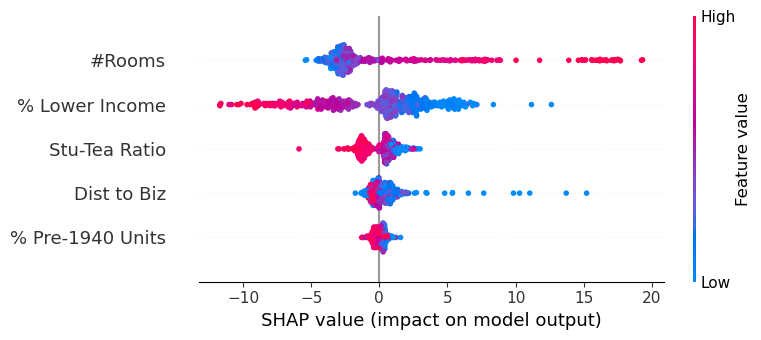

In [5]:
import shap
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values,X)

In [6]:
from sklearn.cluster import KMeans
import numpy as np
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)
ood_cluster = 0
ood_indices = np.where(cluster_labels == ood_cluster)[0]
in_dist_indices = np.where(cluster_labels != ood_cluster)[0]
# 3. Split in-distribution data into train/test
X_in, y_in = X.iloc[in_dist_indices], y.iloc[in_dist_indices]
X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(X_in, y_in, test_size=0.2, random_state=42)

# 4. Train model on in-distribution data
rf_in = RandomForestRegressor(n_estimators=100, random_state=42)
rf_in.fit(X_train_in, y_train_in)

in_preds = rf.predict(X_test_in)
in_r2 = r2_score(y_test_in, in_preds)
in_rmse = np.sqrt(np.mean((y_test_in - in_preds)**2))

# 6. Evaluate on OOD cluster
X_ood, y_ood = X.iloc[ood_indices], y.iloc[ood_indices]
ood_preds = rf_in.predict(X_ood)
ood_r2 = r2_score(y_ood, ood_preds)
ood_rmse = np.sqrt(np.mean((y_ood - ood_preds)**2))

print(f"In-distribution R2: {in_r2:.3f}, RMSE: {in_rmse:.3f}")
print(f"OOD R2: {ood_r2:.3f}, RMSE: {ood_rmse:.3f}")

In-distribution R2: 0.956, RMSE: 1.351
OOD R2: 0.469, RMSE: 6.890


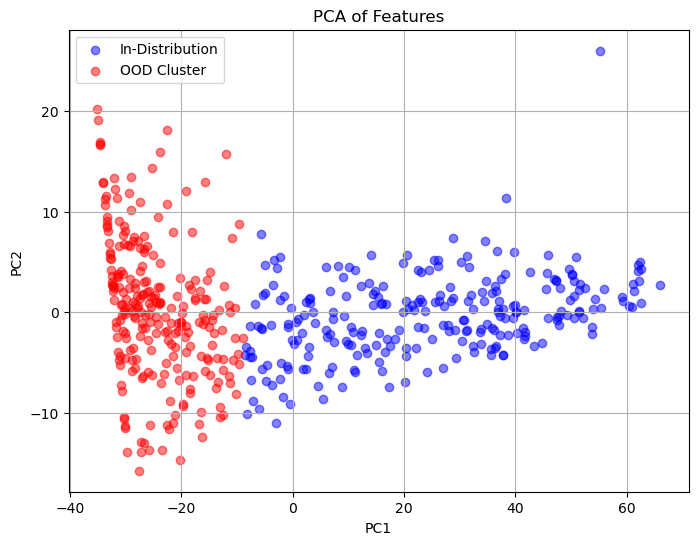

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[in_dist_indices, 0], X_pca[in_dist_indices, 1], c='blue', label='In-Distribution', alpha=0.5)
plt.scatter(X_pca[ood_indices, 0], X_pca[ood_indices, 1], c='red', label='OOD Cluster', alpha=0.5)
plt.legend()
plt.title("PCA of Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [8]:
X_train.columns

Index(['#Rooms', '% Pre-1940 Units', 'Dist to Biz', 'Stu-Tea Ratio',
       '% Lower Income'],
      dtype='object')

In [9]:
print(len(in_dist_indices),len(ood_indices))

254 252


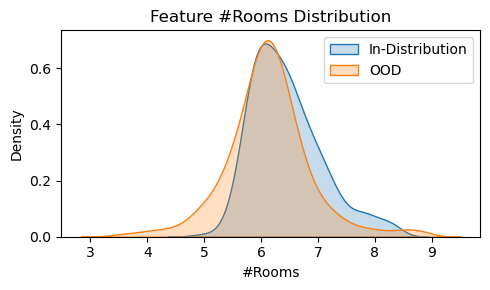

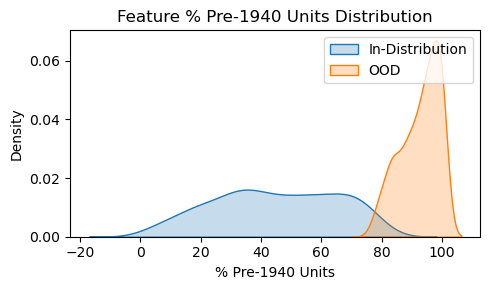

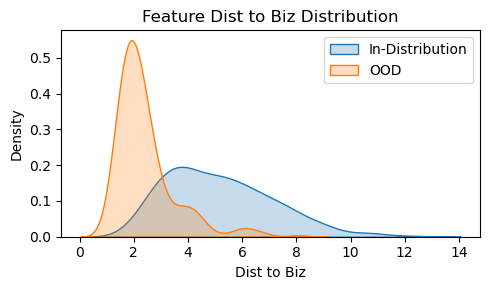

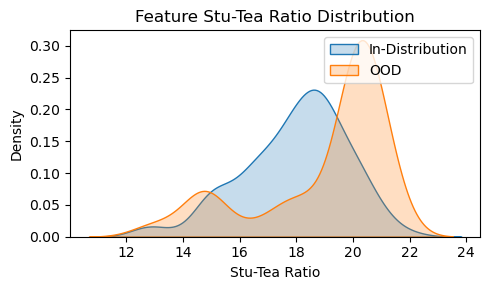

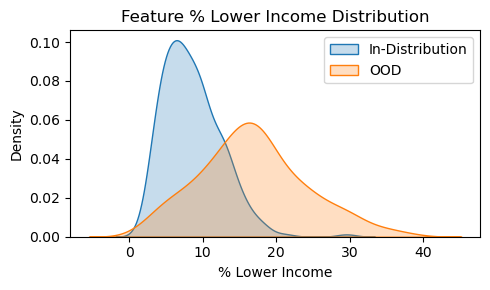

In [10]:
import seaborn as sns
for i in range(X.shape[1]):
    plt.figure(figsize=(5, 3))
    sns.kdeplot(X.iloc[in_dist_indices, i], label='In-Distribution', fill=True)
    sns.kdeplot(X.iloc[ood_indices, i], label='OOD', fill=True)
    plt.title(f'Feature {X_train.columns[i]} Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:
train_preds = rf.predict(X_train_in)

min_index = np.argmin(train_preds)  # min val index
max_index = np.argmax(train_preds)  # max val index
mean_value = np.mean(train_preds)   # mean val 

closest_mean_index = np.argmin(np.abs(train_preds - mean_value))  # 


# Define function f(x) using rf.predict.
def f(x):
    x_df = pd.DataFrame([x], columns=X.columns)
    return float(rf.predict(x_df)[0])

print("predcition",train_preds[[min_index, closest_mean_index, max_index]])
print("labels",y_train_in.iloc[[min_index, closest_mean_index, max_index]].values)


predcition [12.637 26.421 47.988]
labels [10.2 28.1 50. ]


In [12]:
X.columns

Index(['#Rooms', '% Pre-1940 Units', 'Dist to Biz', 'Stu-Tea Ratio',
       '% Lower Income'],
      dtype='object')

In [13]:
def f_in(x):
    x_df = pd.DataFrame([x], columns=X.columns)
    return float(rf_in.predict(x_df)[0])

In [17]:

import sys
sys.path.append("../../")
from utils import explain_prediction
from Approach_ import RelatabilitySolver  # Import lver
from search_strategies import AStarStrategy, GreedyBestFirstStrategy
import time
from utils import explain_prediction

prototypes = X_train_in.iloc[[min_index, closest_mean_index, max_index]].values
prototype_labels = y_train_in.iloc[[min_index, closest_mean_index, max_index]].values
# Initialize the RelatabilitySolver
solver = RelatabilitySolver(
    f=f_in,
    prototypes=prototypes,
    prototype_labels=prototype_labels,
    partitions=4,  # number of grid points between prototype and target
    max_steps=5    # maximum steps in the path
)

index = 3
# Example: Explain a prediction for a test house
test_house = X_test_in.iloc[index].values  # Take first house from test set as example
print("=== Target House ===")
print(f"Actual price: ${y_test_in.iloc[index]:.2f}")
print(f"Predicted price: ${f(test_house):.2f}")
print("\nGenerating explanation...")


preds_train_in = rf.predict(X_train_in) 
# Find and show explanation
explain_prediction(solver, X_train_in, y_train_in, preds_train_in,test_house, threshold=0.1)


=== Target House ===
Actual price: $19.40
Predicted price: $20.50

Generating explanation...
prototype [ 6.375  32.3     3.9454 18.6     9.38  ] label: 28.1 prediction: 25.49899999999997

=== Explanation Path Found ===

Starting Point (Prototype):
Predicted Price: $25.50

Step 1:
------------------------------
Price: $23.45 (-2.05)
Changes made:
  #Rooms: ↓ 0.34

Most Similar Case Found:
  Dataset Index: 45
  Actual Label: $23.40
  Predicted Label: $22.15

Step 2:
------------------------------
Price: $22.84 (-0.61)
Changes made:
  Dist to Biz: ↑ 0.67

Most Similar Case Found:
  Dataset Index: 45
  Actual Label: $23.40
  Predicted Label: $22.15

Step 3:
------------------------------
Price: $22.55 (-0.29)
Changes made:
  Dist to Biz: ↑ 2.02

Most Similar Case Found:
  Dataset Index: 66
  Actual Label: $24.80
  Predicted Label: $24.52

=== Final Result ===
Total Steps: 3
Path Error: 0.3690
Total Price Change: $-2.95


In [22]:
index = 13

# Example: Explain a prediction for a test house
test_house_ood = X_ood.iloc[index].values  # Take first house from test set as example
print("=== OOD Target House ===")
print(f"Actual price: ${y_ood.iloc[index]:.2f}")
print(f"Predicted price: ${f(test_house_ood):.2f}")
print("\nGenerating explanation...")
# Find and show explanation
explain_prediction(solver, X_ood, y_ood, ood_preds,test_house_ood, threshold=0.1)

=== OOD Target House ===
Actual price: $13.90
Predicted price: $14.60

Generating explanation...
prototype [ 8.297  67.      2.4216 13.      7.44  ] label: 50.0 prediction: 48.54700000000002

=== Explanation Path Found ===

Starting Point (Prototype):
Predicted Price: $48.55

Step 1:
------------------------------
Price: $47.99 (-0.56)
Changes made:
  Stu-Tea Ratio: ↑ 4.00

Most Similar Case Found:
  Dataset Index: 125
  Actual Label: $16.20
  Predicted Label: $19.97

Step 2:
------------------------------
Price: $21.82 (-26.17)
Changes made:
  #Rooms: ↓ 2.02

Most Similar Case Found:
  Dataset Index: 125
  Actual Label: $16.20
  Predicted Label: $19.97

Step 3:
------------------------------
Price: $21.62 (-0.19)
Changes made:
  Stu-Tea Ratio: ↑ 4.00

Most Similar Case Found:
  Dataset Index: 190
  Actual Label: $8.40
  Predicted Label: $25.53

Step 4:
------------------------------
Price: $18.80 (-2.83)
Changes made:
  #Rooms: ↓ 0.67

Most Similar Case Found:
  Dataset Index: 190
  A